In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from minigrad import Tensor, NameManager, sin, relu, tanh, sigmoid

sns.set_style('whitegrid')

In [2]:
def convert_simple_type(var):
    var = var.numpy().copy().squeeze()
    if len(var.shape) == 0:
        return float(var)
    else:
        return var.tolist()

def gd(objective_fn, n_epochs, lr, inputs):
    history = []

    for epoch in range(n_epochs):
        for var in inputs:
            var.zero_grad()

        loss = objective_fn(inputs)
        loss.backward()

        history.append({
            "loss": convert_simple_type(loss),
            "vars": [convert_simple_type(var) for var in inputs],
            "grads": [convert_simple_type(var.grad) for var in inputs],
        })

        for var in inputs:
            var._arr -= lr * var.grad.numpy()

        if (n_epochs < 20) or (epoch % (n_epochs // 20) == 0):
            print(loss.numpy())

    return history

### Mínimo de uma onda de seno

In [3]:
NameManager.reset()

def fn(inputs):
    x = inputs[0]
    return sin((x * 2) + 0.5)

x = Tensor(3.5)
history = gd(fn, 10, 0.2, [x])


[[0.93799998]]
[[0.80726691]]
[[0.45052848]]
[[-0.24435302]]
[[-0.85346668]]
[[-0.99139556]]
[[-0.99964739]]
[[-0.99998588]]
[[-0.99999944]]
[[-0.99999998]]


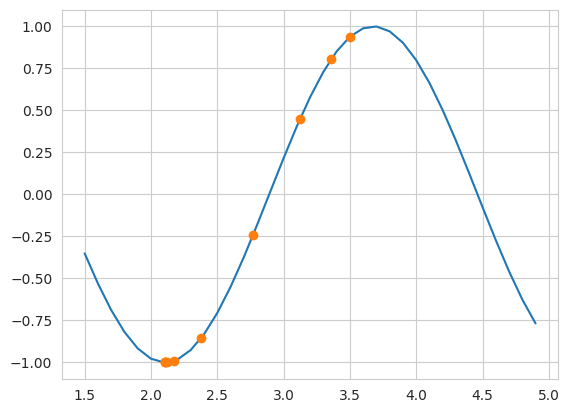

In [4]:
x = [h['vars'][0] for h in history]
y = [h['loss'] for h in history]

x_fn = np.arange(1.5, 5, 0.1)
y_fn = [fn([Tensor(x)]).numpy().squeeze() for x in x_fn]

plt.plot(x_fn, y_fn, '-')
plt.plot(x, y, 'o')
plt.show()

### Regressão de Parábola

In [5]:
NameManager.reset()

# optimize coefficients
a = Tensor(1)
b = Tensor(1)
c = Tensor(1)

class LossFn:
    def __init__(self):
        # generate dataset
        self.x = np.arange(-5, 5, 0.2)
        self.y = -0.5 * self.x ** 2 + 1 * self.x - 5

    def __call__(self, inputs):
        a, b, c = inputs

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = a * (x_i ** 2) + b * x_i + c
            loss = ((y_i - prd))**2 * (1/len(self.x))
            total_loss = total_loss + loss

        return total_loss

loss_fn = LossFn()
params = [a, b, c]
history = gd(loss_fn, 500, 7e-3, params)



[[468.11988]]
[[11.23744573]]
[[8.23565315]]
[[6.03611735]]
[[4.4240224]]
[[3.24247741]]
[[2.37649334]]
[[1.74179181]]
[[1.27660308]]
[[0.93565454]]
[[0.68576477]]
[[0.50261427]]
[[0.36837865]]
[[0.26999399]]
[[0.19788539]]
[[0.14503519]]
[[0.10629994]]
[[0.0779099]]
[[0.05710213]]
[[0.04185159]]


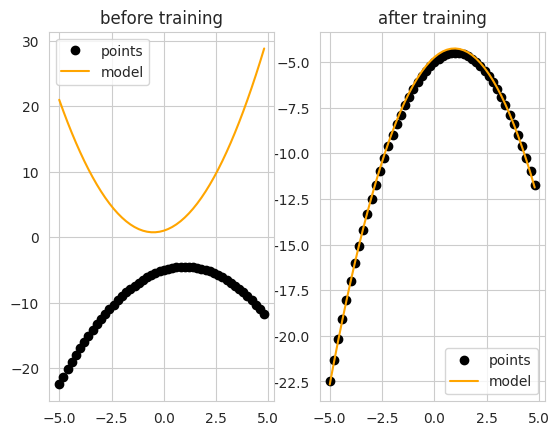

In [6]:

plt.subplot(1, 2, 2)

a0, b0, c0 = history[0]['vars']

init_prd = a0 * loss_fn.x ** 2 + b0 * loss_fn.x + c0
final_prd = a.numpy().squeeze() * loss_fn.x ** 2 + b.numpy().squeeze() * loss_fn.x + c.numpy().squeeze()

plt.subplot(1, 2, 1)
plt.title('before training')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='black', label='points')
plt.plot(loss_fn.x, init_prd, '-', color='orange', label='model')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('after training')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='black', label='points')
plt.plot(loss_fn.x, final_prd, '-', color='orange', label='model')
plt.legend()

plt.show()

### Regressão de Funções Periódicas

In [7]:
NameManager.reset()

class SinRegLossFn:
    def __init__(self):
        self.x = np.arange(-3.0, 3.0, 0.2)
        self.y = np.sin(self.x * 5 + 1)

    def __call__(self, inputs):
        a, m = inputs

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = sin(x_i * m + a)
            loss = (y_i - prd)**2 * (1/len(self.x))
            total_loss = total_loss + loss

        return total_loss

# optimize coefficients
a = Tensor(5.2)
m = Tensor(5)

np.random.seed(1)
loss_fn = SinRegLossFn()
params = [a, m]
history = gd(loss_fn, 20, 2e-1, params)


[[1.46293346]]
[[1.28963745]]
[[1.09799693]]
[[0.90194422]]
[[0.7153339]]
[[0.5485333]]
[[0.40753614]]
[[0.29423467]]
[[0.20722436]]
[[0.14297783]]
[[0.09706196]]
[[0.06508453]]
[[0.04324698]]
[[0.028547]]
[[0.01875356]]
[[0.01227707]]
[[0.0080168]]
[[0.00522509]]
[[0.00340081]]
[[0.00221116]]


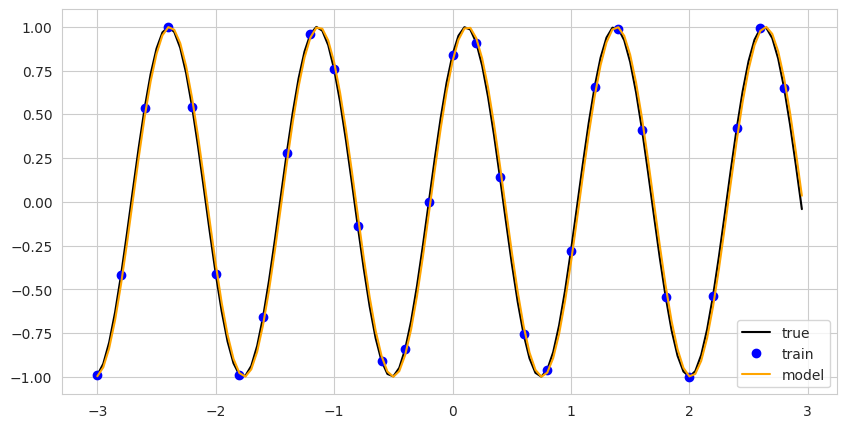

In [8]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x * 5 + 1)

a, m = history[-1]['vars']
prd_y = np.sin(all_x * m + a)

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

## Regressão com Redes Neurais

Fazemos um treino com cada tipo de função de ativação.

In [10]:

NameManager.reset()


def init(nrows, ncols):
    return 0.1 * np.random.normal(size=(nrows, ncols))

class Mlp:
    def __init__(self, act_fn):
        self._act_fn = act_fn

        self._w0 = Tensor(init(64, 1), name='weights')
        self._b0 = Tensor(init(64, 1), name='bias')

        self._w1 = Tensor(init(64, 64), name='weights')
        self._b1 = Tensor(init(64, 1), name='bias')

        self._w2 = Tensor(init(1, 64), name='weights')
        self._b2 = Tensor(init(1, 1), name='bias')

    def forward(self, x):
        z0 = (self._w0 @ x) + self._b0
        h0 = self._act_fn(z0)

        z1 = (self._w1 @ h0) + self._b1
        h1 = self._act_fn(z1)

        y = (self._w2 @ h1) + self._b2

        return y

    def parameters(self):
        return [self._w0, self._b0, self._w1, self._b1]


class NeuralSinRegLossFn:
    def __init__(self, mlp):
        self.x = np.arange(-3.0, 3.0, 0.2)
        self.y = np.sin(self.x)
        self.y += np.random.normal(size=self.y.shape) * 0.2
        self.mlp = mlp

    def __call__(self, inputs):
        # vamos usar a mlp diretamente dado que seus
        # parametros sao armazenados por referencia

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = self.mlp.forward(x_i)
            loss = ((y_i - prd))**2 * (1/len(self.x))
            total_loss = total_loss + loss

        return total_loss

np.random.seed(1)
mlp = Mlp(relu)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 1e-1, params)

[[0.60539212]]
[[0.0852884]]
[[0.05724559]]
[[0.04534972]]
[[0.04023955]]
[[0.03703433]]
[[0.03409913]]
[[0.03161883]]
[[0.02931419]]
[[0.02811975]]
[[0.02716084]]
[[0.02635995]]
[[0.02567843]]
[[0.02507809]]
[[0.02453386]]
[[0.02403302]]
[[0.02356425]]
[[0.0231234]]
[[0.02274007]]
[[0.02235428]]


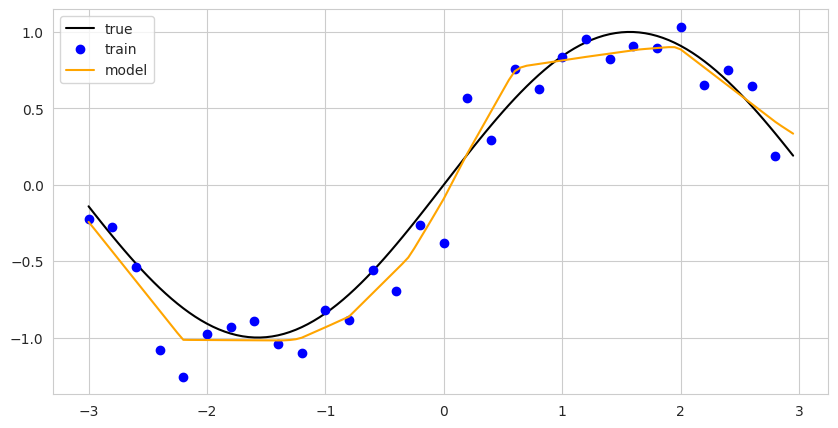

In [11]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

Usando a `tanh` como função de ativação.

In [14]:

np.random.seed(1)
mlp = Mlp(tanh)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 1e-1, params)

[[0.64213178]]
[[0.06429985]]
[[0.03874641]]
[[0.03652965]]
[[0.03516874]]
[[0.03413861]]
[[0.03334055]]
[[0.03271227]]
[[0.03221036]]
[[0.03180353]]
[[0.03146891]]
[[0.0311897]]
[[0.03095348]]
[[0.03075098]]
[[0.03057529]]
[[0.03042116]]
[[0.03028458]]
[[0.03016247]]
[[0.03005242]]
[[0.02995254]]


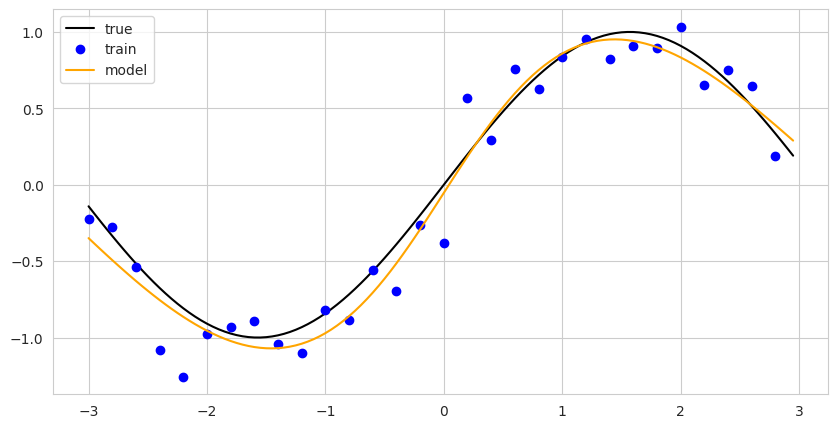

In [15]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

Usando a sigmoide.

In [16]:

np.random.seed(1)
mlp = Mlp(sigmoid)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 7e-1, params)

[[0.61286181]]
[[0.13933899]]
[[0.0890533]]
[[0.06184236]]
[[0.0515937]]
[[0.04756851]]
[[0.04563713]]
[[0.04439965]]
[[0.04341436]]
[[0.04254533]]
[[0.04174883]]
[[0.0410142]]
[[0.04034116]]
[[0.03972749]]
[[0.03916814]]
[[0.03865725]]
[[0.03818912]]
[[0.03775854]]
[[0.03736089]]
[[0.0369924]]


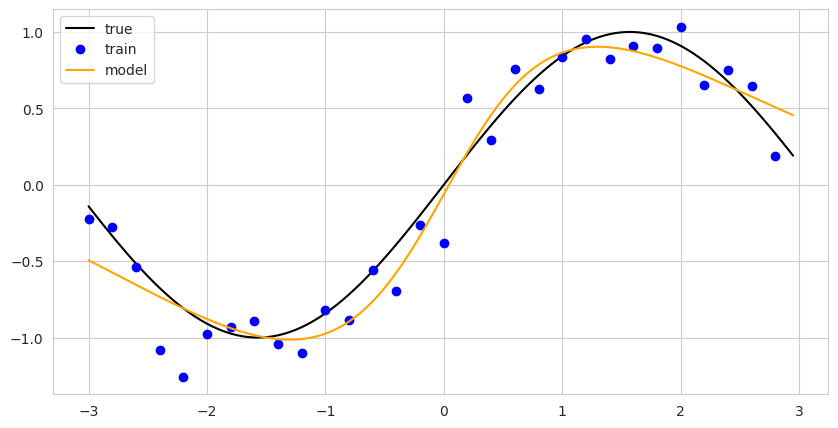

In [17]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()